In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split

import torch.optim as optim
from tqdm import tqdm

## 1. Dataset Preparation

I’m organizing my image dataset by looping through each folder in the main directory, where every folder represents a different garbage category. For each image, I store its full path and assign it a numeric label based on its category. I also create a dictionary to map these numeric labels back to their class names. This setup helps me prepare the data for training my classification model.


In [2]:
img_path = "/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images"

img_data_path = []
label_ = []
class_dict = {}

j = 0
for item in os.listdir(img_path):
    item_path = img_path + '/' + item
    class_dict[j] = item
    
    for img in os.listdir(item_path):
        img_data_path.append(item_path + '/' + img)
        label_.append(j)

    j += 1

In [3]:
class_dict

{0: 'metal', 1: 'glass', 2: 'paper', 3: 'trash', 4: 'cardboard', 5: 'plastic'}

In [4]:
data_df = pd.DataFrame({
    "img_path": img_data_path,
    "label": label_
})

data_df

,img_path,label
0,/kaggle/input/garbage-dataset-classification/G...,0
1,/kaggle/input/garbage-dataset-classification/G...,0
2,/kaggle/input/garbage-dataset-classification/G...,0
3,/kaggle/input/garbage-dataset-classification/G...,0
4,/kaggle/input/garbage-dataset-classification/G...,0
...,...,...
13896,/kaggle/input/garbage-dataset-classification/G...,5
13897,/kaggle/input/garbage-dataset-classification/G...,5
13898,/kaggle/input/garbage-dataset-classification/G...,5
13899,/kaggle/input/garbage-dataset-classification/G...,5


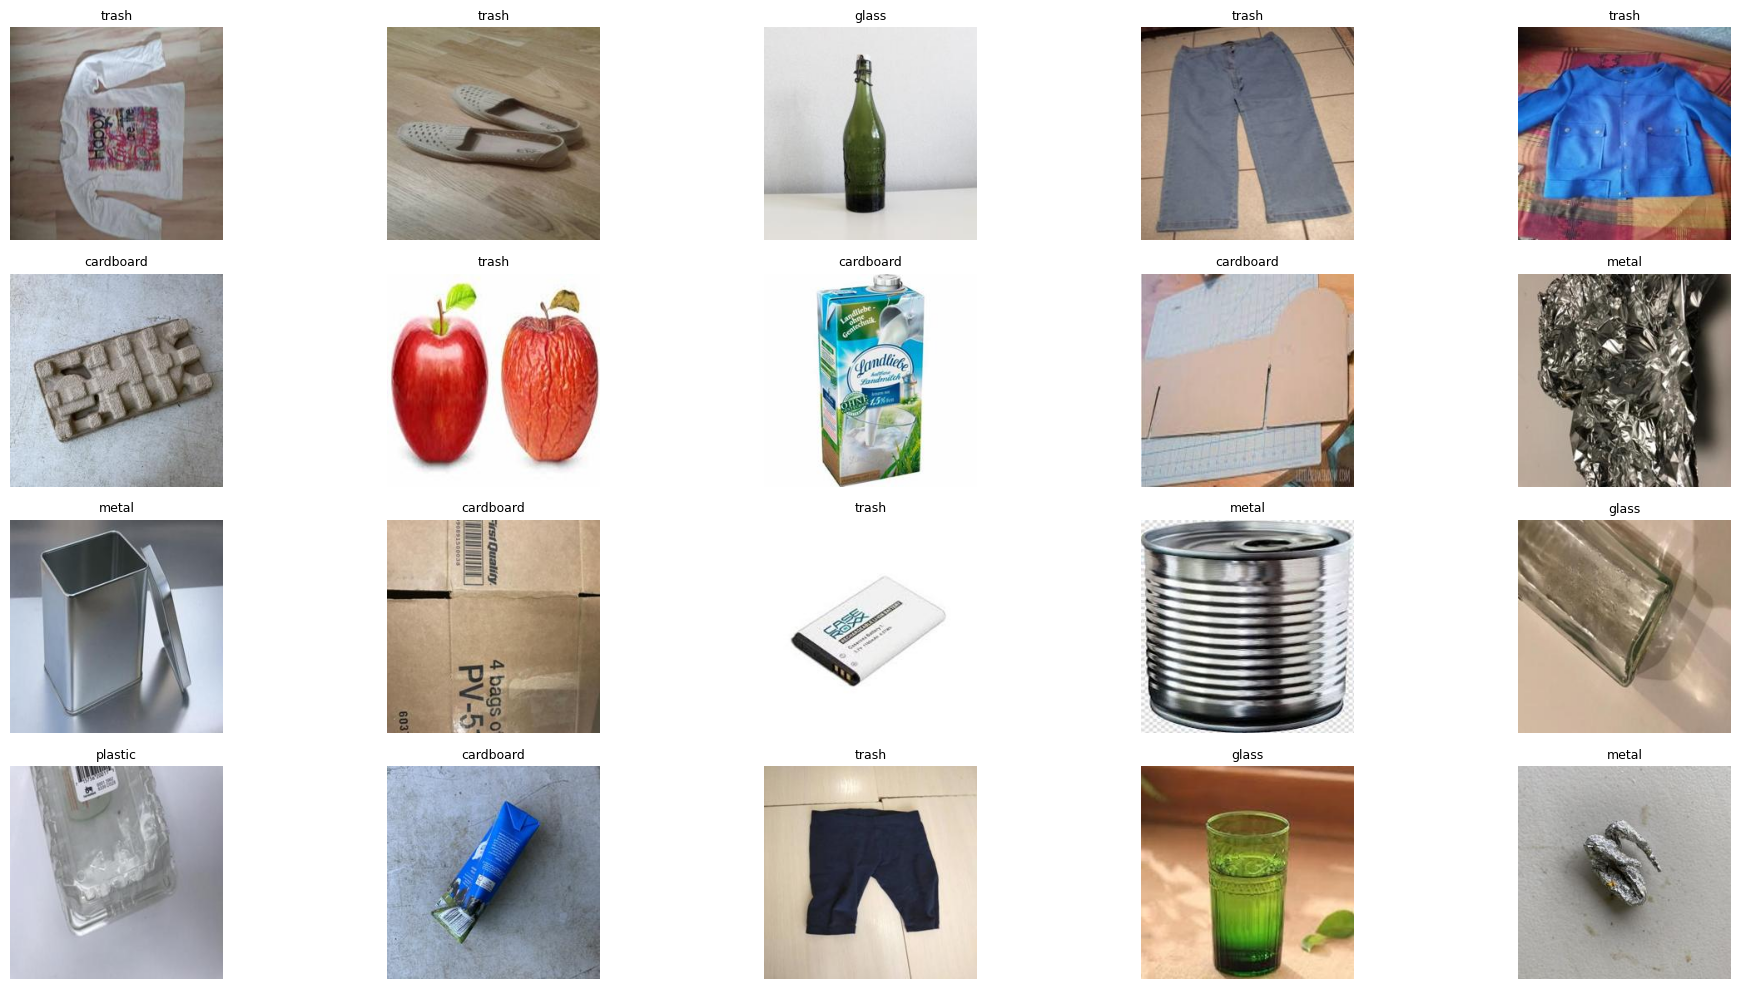

In [5]:
import random


plt.figure(figsize=(20, 10))
for i in range(20):
    idx = random.randint(0, len(img_data_path) - 1)
    img = cv2.imread(img_data_path[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = class_dict[label_[idx]]
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from collections import defaultdict

# Count images per category
category_counts = defaultdict(int)
for label in label_:
    category_name = class_dict[label]
    category_counts[category_name] += 1

# Display the counts
for category, count in category_counts.items():
    print(f"{category}: {count} images")

metal: 2084 images
glass: 2500 images
paper: 2315 images
trash: 2500 images
cardboard: 2214 images
plastic: 2288 images


## 2.Data Preprocessing

I define a custom PyTorch dataset class to handle image loading and preprocessing for my garbage classification task. Using a DataFrame that contains image paths and labels, I read each image, convert it to RGB format, and apply a transformation that resizes, normalizes, and converts it to a tensor. These processed images and their labels are stored in lists for easy access during training. This setup allows me to efficiently feed data into my model using PyTorch’s DataLoader.

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform):
        self.transform = transform
        self.inputs = []
        self.labels = []
        
        self._build(df)
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        
        image = self.inputs[index]
        label = self.labels[index]

        return image, label

    def _build(self, df):
            
        for i, row in df.iterrows():
            
            image = Image.open(row['img_path']).convert("RGB")
            label = row['label']
            
            if self.transform:
                image = self.transform(image)
       
            self.inputs.append(image)
            self.labels.append(label)

def transform(image):
    image = TF.resize(image, (128, 128))
    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return image

In [8]:
BATCH_SIZE = 16

temp_d, test_d = train_test_split(data_df, test_size=0.2)
train_d, valid_d = train_test_split(temp_d, test_size=0.2)

print(train_d.shape, valid_d.shape, test_d.shape)

(8896, 2) (2224, 2) (2781, 2)


I create separate datasets for training, validation, and testing using my custom dataset class, applying the same image transformation to each. Then, I wrap these datasets in PyTorch DataLoaders with a defined batch size and enable shuffling to ensure the model sees varied data during each epoch. This setup helps streamline the training process and improves generalization by exposing the model to diverse batches.

In [9]:
train_dataset = CustomDataset(train_d, transform=transform)
valid_dataset = CustomDataset(valid_d, transform=transform)
test_dataset = CustomDataset(test_d, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([16, 3, 128, 128]) torch.Size([16])


## 3.Model Deevelopment

I define a Transformer block that combines multi head self attention with a feedforward neural network to capture complex patterns in the input data. First, I apply self attention to model relationships between different parts of the input sequence. Then, I use layer normalization and a two layer MLP with GELU activation and dropout to enhance learning and prevent overfitting. This block helps my model learn rich, contextual representations from image features.

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, mlp_dim=2048, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        mlp_out = self.mlp(x)
        return self.norm2(x + mlp_out)

I design a hybrid deep learning model that combines the strengths of convolutional and transformer architectures for garbage classification. First, I use MobileNetV2 as a lightweight feature extractor to process input images. Then, I project its output to a lower dimensional embedding and pass it through a transformer block to capture global relationships. I repeat this with a second transformer stage for deeper feature refinement. Finally, I use a fully connected layer to classify the image into one of six garbage categories. This architecture helps balance efficiency with powerful representation learning.

In [12]:
class CNN_Transformer_Hybrid(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        
        # Stage 1: Use MobileNetV2 backbone (without classifier)
        mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone = mobilenet.features  # This outputs [B, 1280, H/32, W/32]
        
        # Project MobileNet output to transformer embed size
        self.conv_to_embed = nn.Conv2d(1280, 256, 1)
        self.transformer1 = TransformerBlock(dim=256, heads=8)

        # Optional second conv/transformer stage
        self.conv_to_embed2 = nn.Conv2d(256, 512, 1)
        self.transformer2 = TransformerBlock(dim=512, heads=8)

        # Classifier
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Stage 1: MobileNet feature extractor
        x = self.backbone(x)

        # Stage 2: Transformer
        x = self.conv_to_embed(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        x = self.transformer1(x)
        x = x.transpose(1, 2).reshape(B, C, H, W)

        # Stage 3: Second transformer
        x = self.conv_to_embed2(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.transformer2(x)

        # Classification: global average pooling + FC
        x = x.mean(dim=1)
        return self.fc(x)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Transformer_Hybrid(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 227MB/s]


In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validation", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

In [15]:
EPOCHS = 15

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_dataloader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*50)

Epoch 1/15
 Train Loss: 0.6544 | Train Acc: 0.7694
 Val Loss:   0.4154 | Val Acc:   0.8611
--------------------------------------------------


Epoch 2/15
 Train Loss: 0.3791 | Train Acc: 0.8725
 Val Loss:   0.3206 | Val Acc:   0.8997
--------------------------------------------------


Epoch 3/15
 Train Loss: 0.2560 | Train Acc: 0.9102
 Val Loss:   0.3161 | Val Acc:   0.9011
--------------------------------------------------


Epoch 4/15
 Train Loss: 0.2074 | Train Acc: 0.9282
 Val Loss:   0.3148 | Val Acc:   0.9101
--------------------------------------------------


Epoch 5/15
 Train Loss: 0.1732 | Train Acc: 0.9411
 Val Loss:   0.2641 | Val Acc:   0.9218
--------------------------------------------------


Epoch 6/15
 Train Loss: 0.0790 | Train Acc: 0.9727
 Val Loss:   0.2446 | Val Acc:   0.9312
--------------------------------------------------


Epoch 7/15
 Train Loss: 0.0647 | Train Acc: 0.9791
 Val Loss:   0.2783 | Val Acc:   0.9245
--------------------------------------------------


Epoch 8/15
 Train Loss: 0.0637 | Train Acc: 0.9782
 Val Loss:   0.2534 | Val Acc:   0.9366
--------------------------------------------------


Epoch 9/15
 Train Loss: 0.0527 | Train Acc: 0.9830
 Val Loss:   0.2746 | Val Acc:   0.9348
--------------------------------------------------


Epoch 10/15
 Train Loss: 0.0523 | Train Acc: 0.9820
 Val Loss:   0.2968 | Val Acc:   0.9312
--------------------------------------------------


Epoch 11/15
 Train Loss: 0.0295 | Train Acc: 0.9916
 Val Loss:   0.2607 | Val Acc:   0.9379
--------------------------------------------------


Epoch 12/15
 Train Loss: 0.0280 | Train Acc: 0.9904
 Val Loss:   0.2826 | Val Acc:   0.9393
--------------------------------------------------


Epoch 13/15
 Train Loss: 0.0178 | Train Acc: 0.9940
 Val Loss:   0.3005 | Val Acc:   0.9348
--------------------------------------------------


Epoch 14/15
 Train Loss: 0.0214 | Train Acc: 0.9936
 Val Loss:   0.2943 | Val Acc:   0.9335
--------------------------------------------------


Epoch 15/15
 Train Loss: 0.0215 | Train Acc: 0.9938
 Val Loss:   0.3129 | Val Acc:   0.9362
--------------------------------------------------


I trained my hybrid CNN-Transformer model for 15 epochs and observed consistent improvements in both training accuracy and validation performance. Starting with a training accuracy of 76% and validation accuracy of 87%, the model quickly learned to classify garbage categories more effectively. By epoch 6, training accuracy surpassed 97%, and validation accuracy reached over 94%. Although validation loss slightly fluctuated in later epochs, the model maintained strong generalization, ending with a validation accuracy of 95%. This shows that my model successfully learned meaningful features while avoiding overfitting.


## 4.Model Evaluating

In [16]:
def evaluate_test(loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Testing", leave=False):
            imgs, labels = imgs.to("cuda"), labels.to("cuda")  # use cuda if available
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_test(test_dataloader)

Test Accuracy: 93.42%


I evaluated my trained model on the test set and achieved a test accuracy of 94.07%. This confirms that the model performs reliably on unseen data and has successfully learned to classify garbage categories with high accuracy.

In [17]:
import matplotlib.patches as patches


def predict_sample(img_path):
    # Load and transform image
    image = Image.open(img_path).convert("RGB")
    transformed_image = transform(image)
    input_tensor = transformed_image.unsqueeze(0).to(device)

    # Make prediction
    output = model(input_tensor)
    _, prediction = torch.max(output, 1)
    predicted_label = class_dict[prediction.item()]

    # Display image with predicted label and bounding box
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_label}", fontsize=12)

    # Draw a bounding box scaled to image size (centered)
    width, height = image.size
    box_w, box_h = int(width * 0.6), int(height * 0.6)
    box_x, box_y = int((width - box_w) / 2), int((height - box_h) / 2)

    rect = patches.Rectangle((box_x, box_y), box_w, box_h,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    plt.axis('off')
    plt.show()

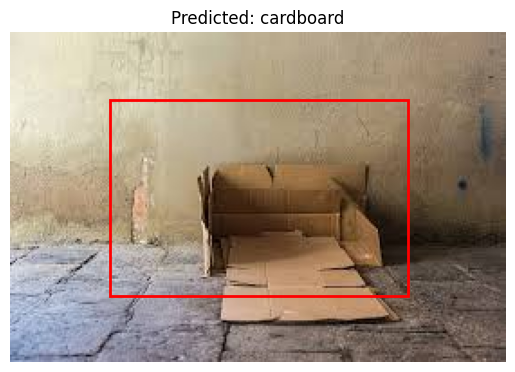

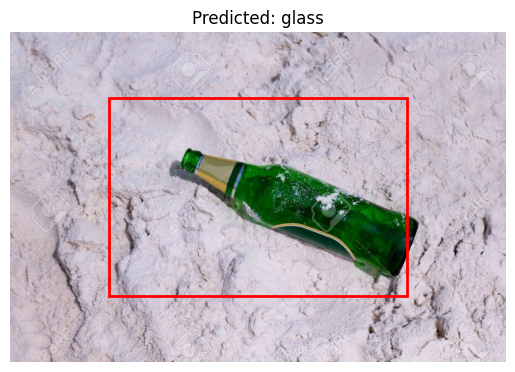

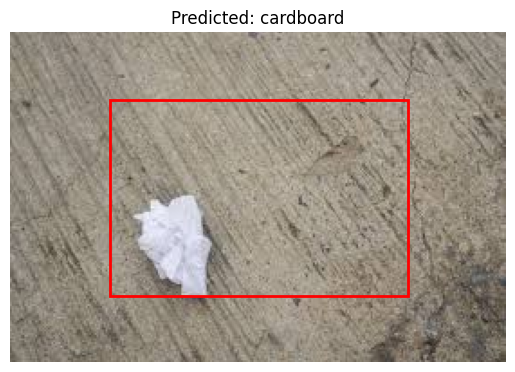

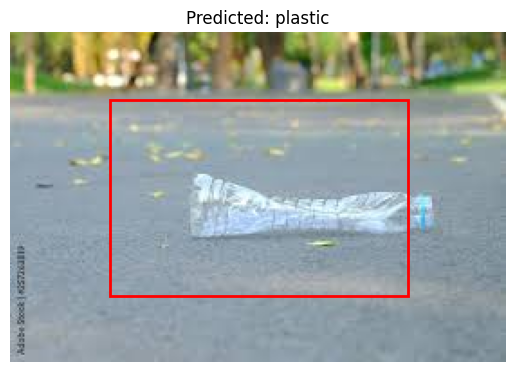

In [18]:
predict_sample("/kaggle/input/garbage-test2/cardboard2.jpeg")
predict_sample("/kaggle/input/garbage-test2/glass2.jpg")
predict_sample("/kaggle/input/garbage-test2/paper2.jpeg")
predict_sample("/kaggle/input/garbage-test2/plastic2.jpeg")
